In [71]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_theme(style="white")

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.cluster import KMeans, SpectralClustering

from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist

from src.downsample import downsamp_audio
import src.embedding_extractor as ee
import src.dimension_reducer as dr
import src.distance_metrics as dm
import src.plotting as plotting

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

one_samp_toy_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/one_samp_toy_downsamp' #toy dataset with one participant recording @16kHz
#two_samp_toy_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/two_samp_toy_downsamp'#toy dataset with two participant recordings @16kHz
two_samp_toy_dir ='/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/020422_postpartum_moms_two_samp_toy'
down_sampled_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/downsamp'#all the data, downsampled to 16kHz
embedding_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings' #location of embeddings save new embeddings load pre-generated ones from here
emb_models = ['emb_ami', 'emb','emb_voxceleb'] #names of pretrained embedding extractor models

#the directory has other csvs and i only want today's
file = [file for file in os.listdir(embedding_dir) if file.startswith("020322")] 

#create a dictionary where each item is the pd df of the embeddings extracted from that model
all_embs = {emb_models[index]: ee.load_embs(os.path.join(embedding_dir,file[index])) for index in np.arange(len(file))}



emb = all_embs[emb_models[1]]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
emb_down = ee.resample_data(emb,1)

In [21]:
plist = emb_down.part_id.unique().astype('int32') 

#loo is leave one out. Creates a dictionary of the downsampled embeddings with the format: {participant_removed:embeddings} for each participant
loo = {'rm' + str(p):
       emb_down[emb_down.part_id!=plist[idx]].reset_index(drop=True) 
       for idx,p in enumerate(plist)
      }

In [23]:
# Reduces dimensions of every set of leave-one-out
#Creates a dictionary: {participant_removed::two-dimension embeddings} for each participant with either tnse or umap

loo_tsne = {rm:dr.run_tsne(ed) for rm, ed in loo.items()}
loo_umap = {rm:dr.run_umap(ed) for rm, ed in loo.items()}
            

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [24]:
#Calculates hausdorf distances between each participants point-cloud after dim reduc
#Creates a dictionary: {participant_removed:hausdorf distance} for each participant
#with hausdorff distances between each participant's two-dimension point-cloud, on either the tsne or umap

loo_haus_tsne = {rm:dm.hausdorff_distances(e2d) for rm, e2d in loo_tsne.items()}
loo_haus_umap = {rm:dm.hausdorff_distances(e2d) for rm, e2d in loo_umap.items()}

Processing row 16, col 16


In [40]:
#flatten the hausdorf distances for plotting and only get column 2 which has the distances (0 and 1 have the pairs of participants)
loo_haus_tsne_flat = {rm:
                      haus.stack().reset_index().iloc[:,2] 
                      for rm,haus in loo_haus_tsne.items()
                     }

loo_haus_tsne_flat = {rm:haus[haus>0] for rm,haus in loo_haus_tsne_flat.items()}

<function matplotlib.pyplot.show(close=None, block=None)>

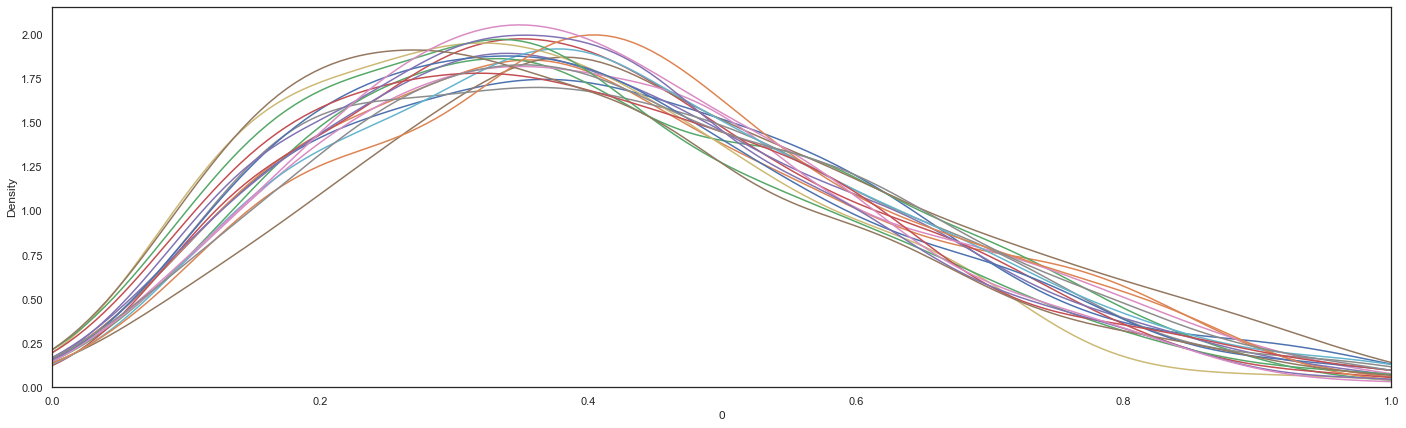

In [48]:
#plots distribution all hausdorff distances. Technically a histogram with easily viewing
fig, ax = plt.subplots(figsize=(24,7))#ncols=3
bins=100

d_plot = [sns.distplot(dist,hist=False) for dist in loo_haus_tsne_flat.values()]
#ax.legend(loc="lower center",bbox_to_anchor=(1.2, 0), ncol=1)
plt.xlim(0,1)
plt.show

In [79]:
ttest = dm.loo_t_test(loo_haus_tsne_flat,equal_var=False)

Processing row 17, col 17


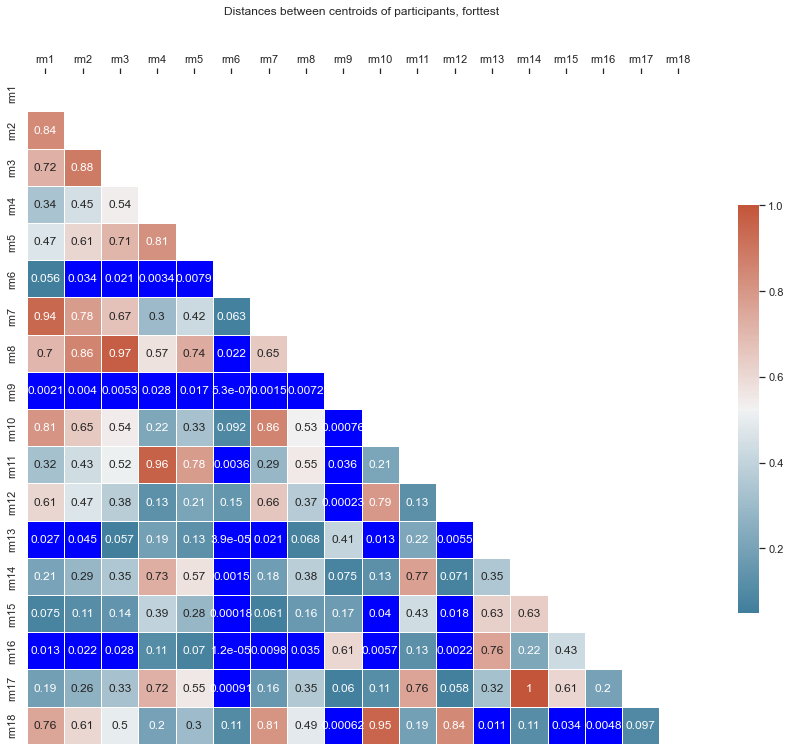

In [81]:
plotting.plot_norm_heatmap(ttest,'ttest')